In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import math

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## General parameters

In [3]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_2Gpc_z1.175_gaussianMock0_truncatedPk_nbarx5.npy')
nbar = mock_catalog.size/mock_catalog.boxsize**3
nmesh = 1024

In [4]:
cellsize = 10
resampler = 'tsc'

## Split model

In [5]:
kN = np.pi*nmesh/mock_catalog.boxsize
kN

1.6084954386379742

In [6]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [7]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [8]:
shot_noise = 404.5190448471664
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise, nbar=nbar)
model.set_pk_model(pk=pkdamped)

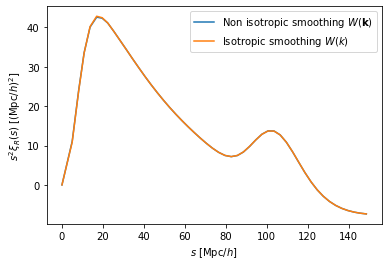

In [9]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

sep = model.sep

cfield = model.pk_3D * model.isotropic_smoothing_kernel_3D()
xifield = cfield.c2r()
from pypower.fft_power import project_to_basis
s, mu, xi = project_to_basis(xifield, edges=(np.linspace(0., 150., 51), np.array([-1., 1.])), exclude_zero=False)[0][:3]
plt.plot(sep, sep**2 * model.xi_R, label=r'Non isotropic smoothing $W(\mathbf{k}$)')
plt.plot(s, s**2 * xi, label='Isotropic smoothing $W(k)$')

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_R(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()

## Shot noise cumulants

In [10]:
fourier_kernel = model.isotropic_smoothing_kernel_3D()
real_space_kernel = fourier_kernel.c2r()

In [24]:
x_vals = list()

for x in real_space_kernel.slabs.x:
    x_vals.append(x[0][0][0])

x_sorted_indices = np.array(x_vals).argsort()

In [26]:
def weights_trapz(x):
    """Return weights for trapezoidal integration."""
    return np.concatenate([[x[1]-x[0]], x[2:]-x[:-2], [x[-1]-x[-2]]])/2.

#def integrate_3D(slabs, field):
intyz_list = list()
i = 0

for x in real_space_kernel.slabs.x:
    z_vals = x[2][0]
    z_sorted_indices = np.array(z_vals).argsort()
    field = real_space_kernel[i][:][z_sorted_indices]
    y_vals = x[1].transpose()[0]
    y_sorted_indices = np.array(y_vals).argsort()
    field = field[i][y_sorted_indices][:]
    weights_z = weights_trapz(z_vals[z_sorted_indices])
    intz = np.sum(field[i]**6 * weights_z[:, None], axis=1)
    weights_y = weights_trapz(y_vals[y_sorted_indices])
    intyz = np.sum(intz * weights_y)
    intyz_list.append(intyz)
    i += 1

weights_x = weights_trapz(np.array(x_vals)[x_sorted_indices])
intg = np.array(intyz_list)[x_sorted_indices]
intxyz = np.sum(intg * weights_x)
intxyz

7.799917962221889e-06

In [12]:
cumulants = [model.smoothed_shot_noise_cumulant(i) for i in range(4)]
cumulants

ValueError: operands could not be broadcast together with shapes (99999,1,1) (255,256,256) 

## Predict when DS1 halos-halos goes to infinite values

In [10]:
def f(x, y, sigma_R, sigma_RR):
    left = np.sqrt(2/np.pi) * sigma_R**2 / sigma_RR * (np.exp(- y**2 / (2*sigma_RR**2)) - np.exp(- x**2 / (2*sigma_RR**2)))
    right = math.erf(y / (np.sqrt(2) * sigma_RR)) - math.erf(x / (np.sqrt(2) * sigma_RR))
    return left - right

In [11]:
size = 100
vals = np.ndarray(shape=(size, size))
delta1 = np.linspace(-2, 2, size)
delta2 = np.linspace(-2, 2, size)

for i in range(size):
    for j in range(size):
        x = delta1[i]
        y = delta2[j]
        vals[i][j] = f(x, y, model.sigma_R, model.sigma_RR)

In [12]:
th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

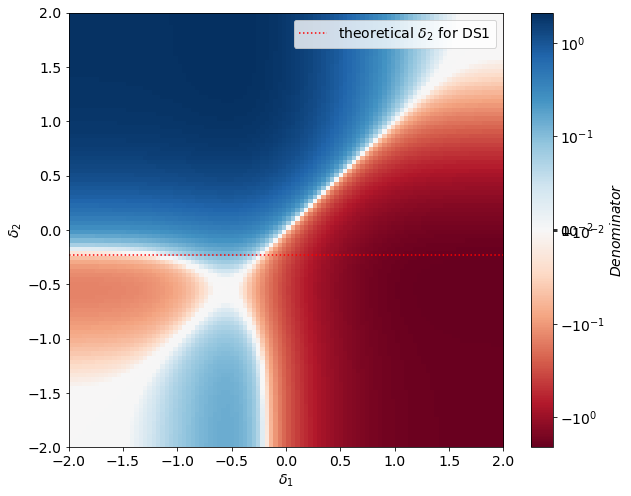

In [13]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10, 8))

ax = plt.gca()

from matplotlib.colors import SymLogNorm, Normalize
#normalize = Normalize(vmin=np.min(vals), vmax=np.max(vals))
normalize = SymLogNorm(linthresh=0.01, linscale=0.01, vmin=np.min(vals), vmax=np.max(vals), base=10)
cmap = plt.get_cmap('RdBu')
extent = np.min(delta1), np.max(delta1), np.min(delta2), np.max(delta2)
c = ax.imshow(vals, cmap=cmap, norm=normalize, extent=extent, origin='lower')

ax.axhline(th_bins[1], ls=':', color='red', label='theoretical $\delta_2$ for DS1')

ax.set_xlabel('$\delta_1$')
ax.set_ylabel('$\delta_2$')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, label='$Denominator$')

plt.legend()
plt.show()

## 10 models with different shot noise values

In [14]:
shot_noise_list = np.linspace(0, 2000, 10)
left_bin_list = np.linspace(-0.3, -0.21774376, 10)
models_list = list()
ccf_randoms_tracers_list = list()
ccf_tracers_list = list()

for i in range(len(left_bin_list)):
    shot_noise = 0
    model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)
    model.set_pk_model(pk=pkdamped)
    models_list.append(model)
    th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)
    bins = th_bins
    bins[1] = left_bin_list[i]
    ccf_randoms_tracers_list.append(model.ccf_randoms_tracers(density_bins=bins))
    ccf_tracers_list.append(model.ccf_tracers(density_bins=bins))

In [15]:
th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)
th_bins

array([       -inf, -0.21875857,  0.21875857,         inf])

## Plot density split CCFs (randoms-tracers)

In [16]:
cmap = plt.get_cmap('plasma')

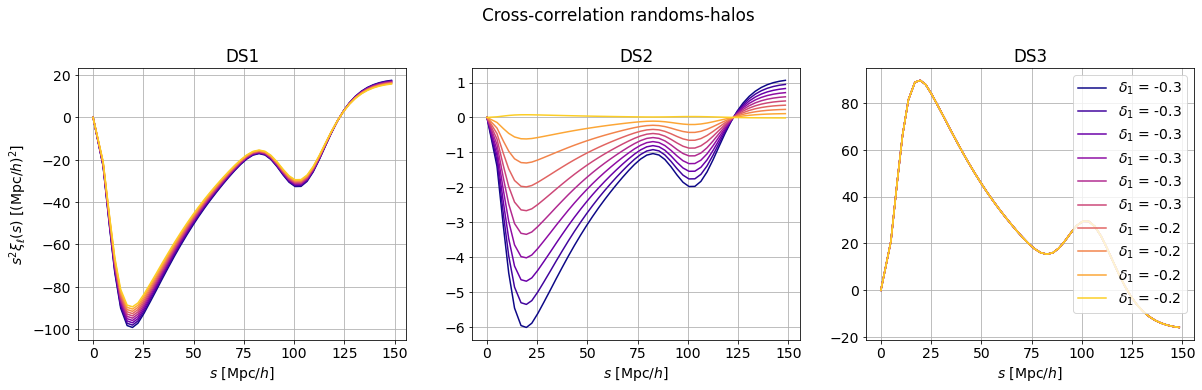

In [17]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    for j in range(len(left_bin_list)):
        axes[i].plot(s, s**2 * ccf_randoms_tracers_list[j][i], label='$\delta_1$ = {:.1f}'.format(left_bin_list[j]), color=cmap(j/len(left_bin_list)))
        axes[i].grid(True)
        axes[i].set_title('DS{}'.format(i+1))    
        axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()

## Plot density split CCFs (tracers-tracers)

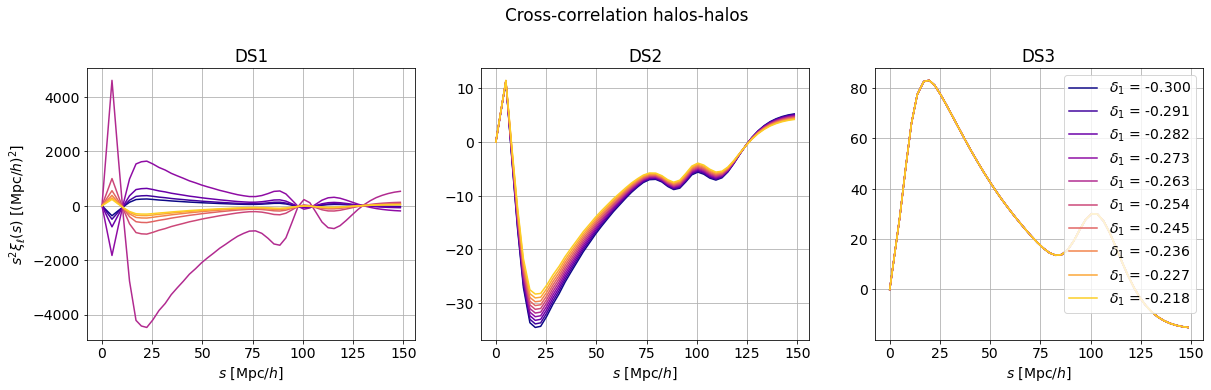

In [18]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    for j in range(len(left_bin_list)):
        axes[i].plot(s, s**2 * ccf_tracers_list[j][i], label='$\delta_1$ = {:.3f}'.format(left_bin_list[j]), color=cmap(j/len(left_bin_list)))
        axes[i].grid(True)
        axes[i].set_title('DS{}'.format(i+1))    
        axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation halos-halos', y=1.05)
plt.show()

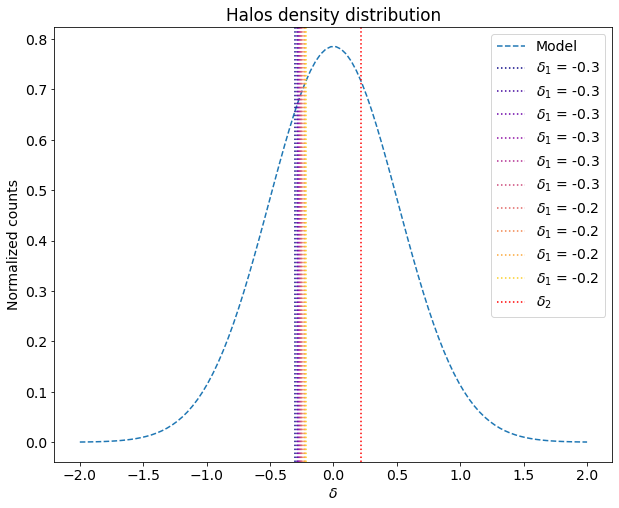

In [27]:
plt.rcParams["figure.figsize"] = (10, 8)

x = np.linspace(-2, 2, 100)

plt.plot(x, scipy.stats.norm.pdf(x=x, loc=0, scale=model.sigma_RR), label=r'Model', color='C0', ls='--')
for j in range(len(left_bin_list)):
    plt.axvline(left_bin_list[j], ls=':', color=cmap(j/len(left_bin_list)), label='$\delta_1$ = {:.1f}'.format(left_bin_list[j]))
plt.axvline(bins[2], ls=':', color='red', label="$\delta_2$")
plt.legend()
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.title('Halos density distribution')
plt.show()